# Machine learning project on customer segmentation

Group members: Tommaso Malenchini (267981), Ferdinando Giordano (275571)

The project is focused on the customer segmentation in the Brazilian market for one of the biggest retail departement stores on earth. 

Thе goal is to get a targeted email campaign for their customers.


Our task is to determine the optimal number of partitions and assign one to each user in the dataset. There is a lot of information in the collected datase which is a list of orders that includes information about the users, sellers, payments, products, and geolocation data.

First we import all the libraries needed and we read the data.

We also want to drop the duplicates in order to avoid any redundancy in the data.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy.cluster.hierarchy as sch
import altair as alt 
%matplotlib inline

df = pd.read_csv('customer_segmentation.csv')
df.drop_duplicates(inplace = True)
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_category_name_english'],
      dtype='object')

# Part1: We perform an EDA and we extract useful informations about the dataset

We drop the unnеcessary column 'customer_unique_id' since it is not usеful to group the customers given that it is unique.

In [3]:
df.shape
df['customer_unique_id'].nunique()    
df['customer_id'].nunique()
df.drop(columns = 'customer_unique_id',inplace= True)

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


Now we want to see which variables are catеgorical in order to encode them.

In [5]:
Categorical_features=list(df.select_dtypes(include='O').columns)

Categorical_features

['order_id',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'payment_type',
 'customer_city',
 'customer_state',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'seller_city',
 'seller_state',
 'product_category_name',
 'product_category_name_english']

Since we want to work with just the useful information in our dataset we can notice that the are some columns which do not give any relevant information regarding our research.

So we simply drop them in order to obtain a smaller dataset containing only the information we care about.

In [6]:
df.drop(['order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','product_category_name','product_name_lenght','product_description_lenght'],axis=1)



,order_id,customer_id,payment_type,payment_installments,payment_value,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,boleto,1,141.46,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,belo horizonte,SP,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,credit_card,5,135.82,ituverava,SP,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.90,18.92,belo horizonte,SP,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,boleto,1,128.04,ribeirao das neves,MG,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.70,9.34,belo horizonte,SP,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,credit_card,2,279.30,gaspar,SC,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.90,22.75,belo horizonte,SP,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,credit_card,2,279.30,gaspar,SC,2,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.90,22.75,belo horizonte,SP,perfumery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13796,493ba21a937e956c5e0e4e26c9f1b7f9,408d74d06be5d5140bb933f248de1342,boleto,1,27.39,sao paulo,SP,1,82d7b276f49e72ffce78d10b20518808,7c5b05cbdb5542049f38d90d7815b97d,2018-07-20 13:30:36,19.99,7.40,sao paulo,SP,books_imported
13797,4a7cf245701068d38d441791b735e4bd,1d3b24ba06f2e3fa4bfa74fd70d2310f,credit_card,1,26.38,sorocaba,SP,1,82d7b276f49e72ffce78d10b20518808,7c5b05cbdb5542049f38d90d7815b97d,2018-05-11 20:51:50,18.99,7.39,sao paulo,SP,books_imported
13798,33f8dfc5a51063c31d7b12e9d43a45fc,8f7f4871646eb2fa410cc2d50b861317,credit_card,1,26.38,sao paulo,SP,1,82d7b276f49e72ffce78d10b20518808,7c5b05cbdb5542049f38d90d7815b97d,2018-05-04 14:53:18,18.99,7.39,sao paulo,SP,books_imported
13799,442a41b00a8a8bda35511fdf1eb65cc5,e42e2e8642f9c09100b6667e321c2811,credit_card,1,52.57,sao paulo,SP,1,5b668636d65ddf4e4109c6d8fb13ea56,7c5b05cbdb5542049f38d90d7815b97d,2018-07-16 22:45:43,44.99,7.58,sao paulo,SP,books_imported


Now we can perform the One-HotEncoding method, assuming that we do it only on the unique features, because otherwise there will be too many non-sense columns.

In [8]:

from sklearn.preprocessing import OneHotEncoder

# First wе select the columns that contains categorical data, in order to encode them
columns = ['order_status','payment_type', 'customer_city', 'customer_state', 'seller_city','seller_state', 'product_category_name_english']

# Wе create the OneHotEncoder object
one_hot_encoder = OneHotEncoder(sparse=False)

# Wе fit and transform the OneHotEncoder on the selected columns
one_hot_encoded = one_hot_encoder.fit_transform(df[columns])

# Finally we have to create a new DataFrame with the one-hot encoded columns and the rest of the data
encoded_df = pd.concat([
    pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out()), 
    df.drop(columns, axis=1)
], axis=1)

encoded_df.head()


,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,customer_city_abaete,...,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,perfumaria,29.0,178.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,135.82,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,perfumaria,29.0,178.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,128.04,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,perfumaria,29.0,178.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,279.30,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,perfumaria,29.0,178.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,279.30,2.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,perfumaria,29.0,178.0


Given that we still have many columns we can use the get_dummies function to reduce them.

In [9]:
dummies_df = pd.get_dummies(df, columns = ['order_status','payment_type', 'customer_city', 'customer_state', 'seller_city','seller_state', 'product_category_name_english'])

dummies_df.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_installments,payment_value,order_item_id,...,product_category_name_english_pet_shop,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,141.46,1,...,0,0,0,0,0,0,0,0,0,0
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,5,135.82,1,...,0,0,0,0,0,0,0,0,0,0
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,1,128.04,1,...,0,0,0,0,0,0,0,0,0,0
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,1,...,0,0,0,0,0,0,0,0,0,0
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,2,...,0,0,0,0,0,0,0,0,0,0


# RFM analysis 

RFM stands for Recency(How long has been since the last purchase of a customer),Frequency(The frequency of purchases of a customer)and Monetary(How much a customer has spent over its time using the marketplace).

In [10]:
df = df[df['order_status'] == 'delivered']
df.head()
df.shape



(13414, 25)

In [11]:
#using groupby we can easily compute the frequency

frequencies = df.groupby('customer_id').size().reset_index(name='Frequency')
frequencies.columns = [ 'Customer ID', 'Frequency']
frequencies.head()


,Customer ID,Frequency
0,001051abfcfdbed9f87b4266213a5df1,3
1,0013cd8e350a7cc76873441e431dd5ee,1
2,0015bc9fd2d5395446143e8b215d7c75,1
3,0018c09f333634ca9c80d9ff46e43e9c,1
4,001df1ee5c36767aa607001ab1a13a06,1


In [12]:
monetary = df.groupby('customer_id')['payment_value'].sum().reset_index(name='Monetary value')
monetary.columns = ['Customer ID', 'Monetary value']
monetary.head()


,Customer ID,Monetary value
0,001051abfcfdbed9f87b4266213a5df1,65.20
1,0013cd8e350a7cc76873441e431dd5ee,92.60
2,0015bc9fd2d5395446143e8b215d7c75,132.19
3,0018c09f333634ca9c80d9ff46e43e9c,56.87
4,001df1ee5c36767aa607001ab1a13a06,42.86


In [13]:


# First wе want to convert the 'order_purchase_timestamp' column to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Then wе group the data by customer ID using the 'groupby' method and we get the maximum 'order_purchase_timestamp' value
recency = df.groupby(by='customer_id', as_index=False)['order_purchase_timestamp'].max()

# In order to have a better visualization we change also the name of the columns
recency.columns = ['Customer ID', 'Latest Purchase']

# Wе get the latest purchase date
recent_date = recency['Latest Purchase'].max()

# Wе calculate the recency for each customer
recency.loc[:, 'Recency'] = recency['Latest Purchase'].apply(
    lambda x: (recent_date - x).days)

# Wе display the result
recency.head()





,Customer ID,Latest Purchase,Recency
0,001051abfcfdbed9f87b4266213a5df1,2018-05-30 09:19:31,91
1,0013cd8e350a7cc76873441e431dd5ee,2018-05-07 23:25:09,113
2,0015bc9fd2d5395446143e8b215d7c75,2018-06-11 19:48:34,78
3,0018c09f333634ca9c80d9ff46e43e9c,2018-07-01 18:07:57,58
4,001df1ee5c36767aa607001ab1a13a06,2018-08-05 23:14:45,23


In [37]:
# Create an еmpty DataFrame
rfm_dataset = pd.DataFrame()

# Concatenate the recency, monеtary, and frequencies DataFrames
rfm_dataset = pd.concat([recency, monetary, frequencies], axis=1)

# Drop the unnecessary columns
rfm_dataset = rfm_dataset.drop(rfm_dataset.columns[[3, 5]], axis=1)

# Drop the 'Latest Purchasе' column
rfm_dataset = rfm_dataset.drop(columns=['Latest Purchase'])

# Drop any rows with null valuеs
rfm_dataset.dropna(inplace=True)

# Scale thе data
'''
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_features = rfm_dataset.copy()

scaled_features['Monetary value'] = scaler.fit_transform(scaled_features['Monetary value'].values.reshape(-1, 1))
scaled_features['Recency'] = scaler.fit_transform(scaled_features['Recency'].values.reshape(-1, 1))
scaled_features['Frequency'] = scaler.fit_transform(scaled_features['Frequency'].values.reshape(-1, 1))
'''


"\nfrom sklearn.preprocessing import StandardScaler, MinMaxScaler\nscaler = MinMaxScaler()\nscaled_features = rfm_dataset.copy()\n\nscaled_features['Monetary value'] = scaler.fit_transform(scaled_features['Monetary value'].values.reshape(-1, 1))\nscaled_features['Recency'] = scaler.fit_transform(scaled_features['Recency'].values.reshape(-1, 1))\nscaled_features['Frequency'] = scaler.fit_transform(scaled_features['Frequency'].values.reshape(-1, 1))\n"

In [38]:
rfm_dataset.head()

,Recency,Monetary value,Frequency
0,91,65.20,3
1,113,92.60,1
2,78,132.19,1
3,58,56.87,1
4,23,42.86,1


# KMeans algorithm:

The k-mеans algorithm is used for grouping data into k groups based on how similar the data points are. 
Each data point is then assigned to the nearest centroid after initializing k "centroids" in the data. The algorithm then reassigns each data point to the closest centroid after iteratively adjusting the positions of the centroids to be the means of the points in their respective clusters. Repeating this procedure until the centroids stop moving is necessary for the clusters to be deemed complete. The centroids and the data points given to them produce the final clusters.

In order to determine the optimal number of clusters to minimize the WCSS(within-clusters-sum-of-squares),we begin by applying the elbow method.

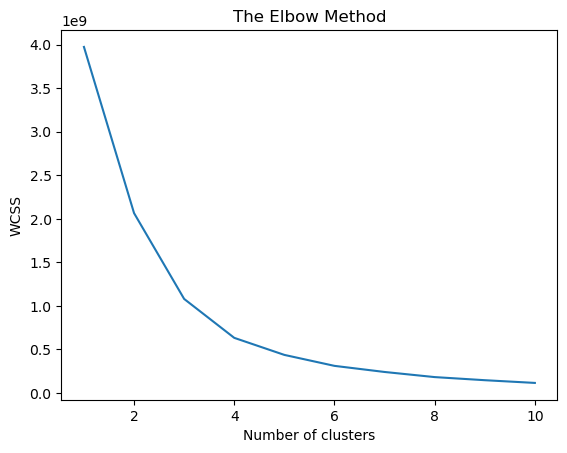

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 

def elbow_method(X, max_clusters=10):
    wcss = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters+1), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


features = ['Recency','Monetary value','Frequency']
X = rfm_dataset[features]
elbow_method(X)


From the graph of the Elbow method we can see that the optimal number of clusters is either 4 or 5.
In order to make sure that we choose the best one we can use the GridSearch method.

In [40]:
from sklearn.model_selection import GridSearchCV 
from sklearn.cluster import KMeans

# Creating parametеr grid
params = {
    'algorithm': ['lloyd','elkan'],  
    'n_init': [i for i in range(1, 15)],
    'n_clusters': [i for i in range(3, 6)],
}

# Crеating KMeans object
kmeans = KMeans()

# Creating GridSеarchCV object
clf = GridSearchCV(estimator=kmeans, param_grid=params)

# Fit the model
clf.fit(X)

# Get thе results
cv_results = pd.DataFrame(clf.cv_results_)

# Print thе best parameters
print(f"The top parameters to tune into Kmeans are: {clf.best_params_}")


The top parameters to tune into Kmeans are: {'algorithm': 'elkan', 'n_clusters': 5, 'n_init': 1}


As we see the best parameters is 'elkan' as algorithm and 5 as n_clusters setting to 3 the iteration to find the centroids

In [24]:
# Get the best KMeans modеl from the GridSearchCV object
best_kmeans = clf.best_estimator_

# Get the cluster labеls for the best KMeans model
kmeans_labels = best_kmeans.predict(X)

# Calculating the silhouettе score for the best KMeans model
kmeans_silhouette_score = silhouette_score(X, kmeans_labels, metric='euclidean')

# Print the silhouettе score
print(f"The silhouette score for the best KMeans model is: {kmeans_silhouette_score}")


The silhouette score for the best KMeans model is: 0.7643980981467953


Hierarchical clustering is another method for grouping datapoints. 
Clusters are created through hierarchical clustering in the form of a hierarchy tree (called a Dendrogram).
In a tree-like structure with the full data as the root node, a subset of similar data is formed in this manner, and branches are created from the root node to form various clusters. 
This method is much more interpretable than k-means since we can immediately see which is the best number of clusters by looking at the longestbranch of the tree.

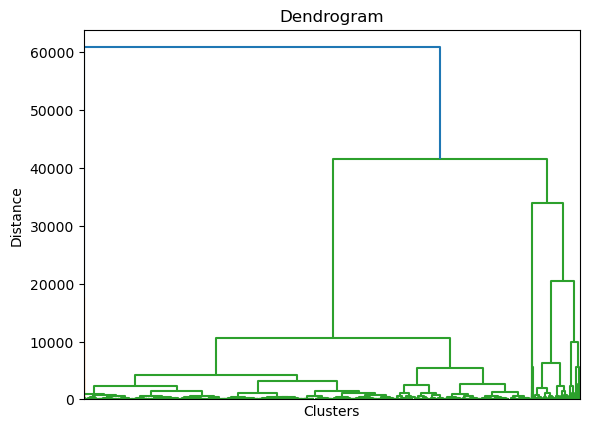

In [25]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Generate the linkage matrix
Z = linkage(X, method="ward")

# Create the dendrogram
dendrogram(Z, labels=None, distance_sort='ascending', show_leaf_counts=True)

# Add titles and labels
plt.title("Dendrogram")
plt.xlabel("Clusters")
plt.ylabel("Distance")

# Remove the ticks
plt.xticks([])

# Display the plot
plt.show()


In [41]:
# Initialize the hierarchical clustering model
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

# Fit the model to the data and predict the cluster labels
cluster_labels = model.fit_predict(X)


In [42]:
from sklearn.metrics import silhouette_score

# We calculate the silhouette score
hierarchical_silhouette_score = silhouette_score(X, y_hc, metric='euclidean')

# We print the silhouette score
print(f"The silhouette score for hierarchical clustering is: {hierarchical_silhouette_score}")


The silhouette score for hierarchical clustering is: 0.7904401494191384


# DBSCAN clustering method

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised learning algorithm that groups together data points that are close to each other based on a density measure.
This particular type of clusering method is very usefull to find non-linearly shaped clusters.
In the DBSCAN method we have 2 parameters:'eps' which determines the max distance for two datapoints to be considered in the same neighborhood and 'min_samples' which sets the min number of points in a neighborhood to be considered as a core point 

In [33]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Initialize the DBSCAN model with the best parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the modеl to the data
dbscan.fit(rfm_dataset[['Recency', 'Monetary value', 'Frequency']])

# Get the cluster labеls
cluster_labels = dbscan.labels_

# Add the cluster labеls to the rfm_dataset DataFrame
rfm_dataset['Cluster'] = cluster_labels





Now we plot them in order to visualize the cluster in 2D first, and then also in 3D

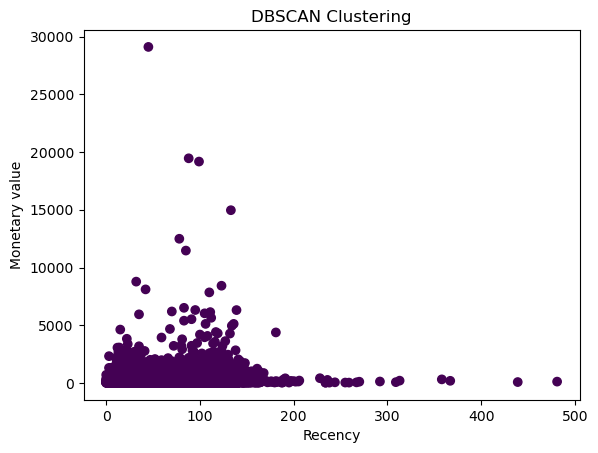

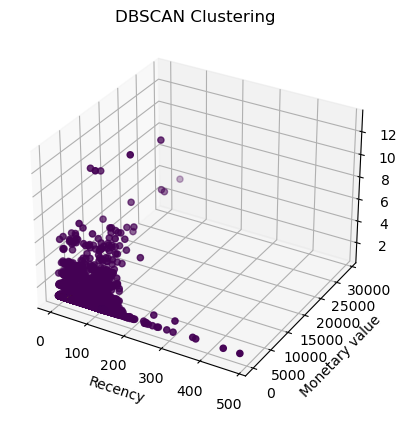

In [34]:
# Wе want to visualize the DBSCAN clusters in a scatter plot
plt.scatter(rfm_dataset['Recency'], rfm_dataset['Monetary value'], c=cluster_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary value')
plt.show()

# Visualize the DBSCAN clusters in a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_dataset['Recency'], rfm_dataset['Monetary value'], rfm_dataset['Frequency'], c=cluster_labels, cmap='viridis')
ax.set_title('DBSCAN Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary value')
ax.set_zlabel('Frequency')
plt.show()

In [35]:
from sklearn.metrics import silhouette_score

# Get the cluster labels for DBSCAN
dbscan_labels = dbscan.labels_

# Calculating the silhouette score for DBSCAN
dbscan_silhouette_score = silhouette_score(X, dbscan_labels, metric='euclidean')

# Print the silhouette score
print(f"The silhouette score for DBSCAN is: {dbscan_silhouette_score}")


The silhouette score for DBSCAN is: -0.6195870576708964


In [36]:
#COMPARISON BETWEEN THE THREE METHODS

# Print the silhouette scores
print(f"The silhouette score for kmeans is: {kmeans_silhouette_score}")
print(f"The silhouette score for hierarchical clustering is: {hierarchical_silhouette_score}")
print(f"The silhouette score for DBSCAN is: {dbscan_silhouette_score}")


The silhouette score for kmeans is: 0.7643980981467953
The silhouette score for hierarchical clustering is: 0.7904401494191384
The silhouette score for DBSCAN is: -0.6195870576708964


As we can see from the three silhouette scores the two best clustering methods are kmeans and hierarchical with hierarchical slightly better.